# Visualization of generated synthetic graphs on REDDIT-BINARY dataset

In [1]:
import networkx as nx
from torch_geometric.datasets import TUDataset
import os.path as osp
from gmixup import prepare_dataset_onehot_y
from utils import split_class_graphs
from graphon_estimator import universal_svd, largest_gap
from utils import align_graphs, stat_graph
import matplotlib.pyplot as plt
import numpy as np
import random
from utils import two_graphons_mixup
from torch_geometric.utils import to_dense_adj

C:\Users\vukdj\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_name = 'REDDIT-BINARY'

data_path = './'
align_max_size = 500
lam_range=[0.005, 0.01]
seed = 45
random.seed(seed)

path = osp.join(data_path, dataset_name)
dataset = TUDataset(path, name=dataset_name)
dataset = list(dataset)
train_nums = int(len(dataset) * 0.7)

for graph in dataset:
    graph.y = graph.y.view(-1)

dataset = prepare_dataset_onehot_y(dataset)
random.shuffle(dataset)
avg_num_nodes, avg_num_edges, avg_density, median_num_nodes, median_num_edges, median_density = stat_graph(
    dataset)
print('Median num nodes: ', int(median_num_nodes))
class_graphs = split_class_graphs(dataset)
print('Finished splitting class graphs')

graphon_size = 50
# graphon_size = int(median_num_nodes)

Median num nodes:  304
Finished splitting class graphs


Finished aligning graphs of label  [1. 0.]


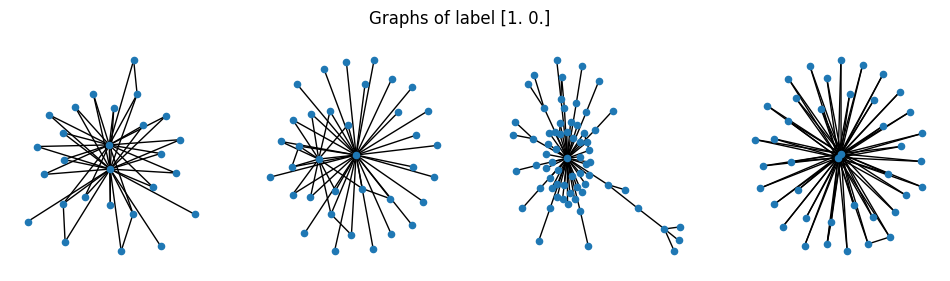

Finished aligning graphs of label  [0. 1.]


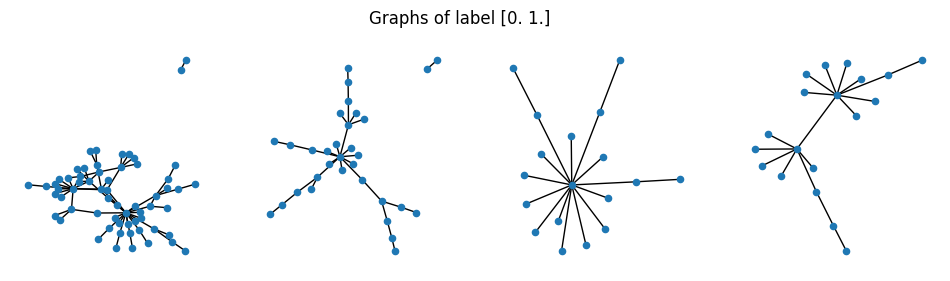

In [7]:
graphons = []
for i, (label, graphs) in enumerate(class_graphs):
    align_graphs_list, normalized_node_degrees, max_num, min_num, sum_graph = align_graphs(graphs[:align_max_size], padding=True, N=int(graphon_size))
    print('Finished aligning graphs of label ', label)
    graphon = largest_gap(align_graphs_list, k=graphon_size, sum_graph=sum_graph)
    np.fill_diagonal(graphon, 0)  # Confirmed in correspondence with the author
    graphons.append((label, graphon))

    fig, ax = plt.subplots(1, 4, figsize=(12, 3), facecolor='w')
#     for axis, graph in zip(ax, random.sample([graph for graph in graphs if graph.shape[0]<80], 4)):
    for axis, graph in zip(ax, random.sample([graph for graph in graphs if graph.num_nodes<80], 4)):
        #         g = nx.from_numpy_matrix(graph) # get adjacency matrix from graph
        g = nx.from_edgelist(graph.edge_index.T.tolist())
        nx.draw_spring(g, ax=axis, node_size=20)
    fig.suptitle(f'Graphs of label {label}')
    plt.savefig(f'../fig/graphs_reddit_{i}.png', facecolor='white', bbox_inches='tight')
    plt.show()

graphon info: label:[1. 0.]; mean: 0.053888000547885895, shape, (50, 50)
graphon info: label:[0. 1.]; mean: 0.04720799997448921, shape, (50, 50)


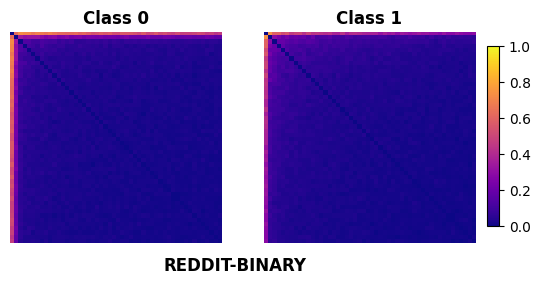

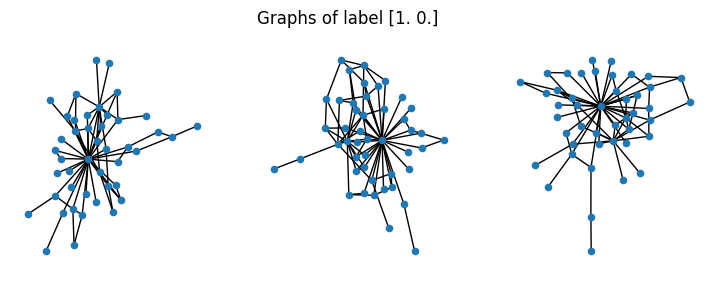

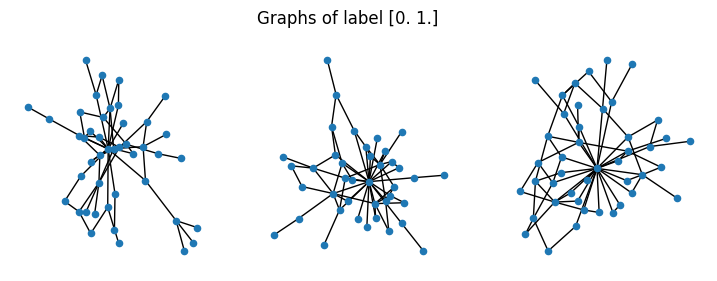

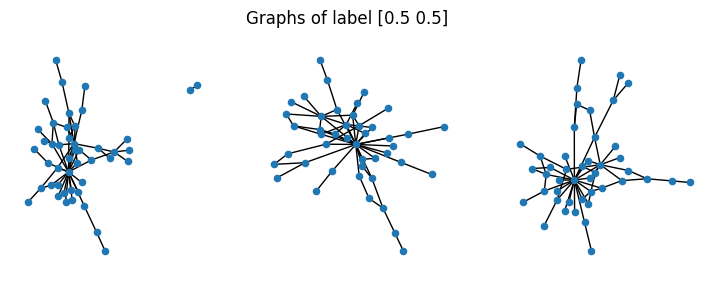

In [8]:
fig, ax = plt.subplots(1, len(graphons), figsize=(6, 3), facecolor='w')
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
for (label, graphon), axis, i in zip(graphons, ax, range(len(graphons))):
    print(f"graphon info: label:{label}; mean: {graphon.mean()}, shape, {graphon.shape}")
    im = axis.imshow(graphon, vmin=0, vmax=1, cmap=plt.cm.plasma)
    axis.set_title(f"Class {i}", weight="bold")
    axis.axis('off')

fig.colorbar(im, cax=cbar_ax, orientation='vertical')
fig.suptitle(dataset_name, y=0.1, weight="bold")

num_sample = 3
new_graphs_10 = []
new_graphs_01 = []
new_graphs_0505 = []
two_graphons = random.sample(graphons, 2)
new_graphs_10 += two_graphons_mixup(two_graphons, la=1, num_sample=num_sample)
new_graphs_01 += two_graphons_mixup(two_graphons, la=0, num_sample=num_sample)
new_graphs_0505 += two_graphons_mixup(two_graphons, la=0.5, num_sample=num_sample)

for i, graph_type in enumerate((new_graphs_10, new_graphs_01, new_graphs_0505)):
    fig, ax = plt.subplots(1, 3, figsize=(9, 3), facecolor='w')
    for axis, graph in zip(ax, graph_type):
        g = nx.from_numpy_matrix(to_dense_adj(graph.edge_index)[0].numpy())
        nx.draw_spring(g, ax=axis, node_size=20)
    plt.suptitle(f'Graphs of label {graph_type[0].y.numpy()}')
    plt.savefig(f'../fig/graphs_reddit_new_{i}.png', facecolor='white', bbox_inches='tight')
    plt.show()